# Structured Optimization
## Loic Landrieu. Feb 2019

# 1 - Data and Library Loading

In [3]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
from sklearn.cluster import KMeans
random.seed(1)

1/ Load and plot the training data. Which model seems to have generated the data? In particular, how many "centroids" can you count?

3 or 4

In [4]:
data_train = np.genfromtxt('train.dat', delimiter=" ", dtype='f8')
data_test = np.genfromtxt('test.dat', delimiter=" ", dtype='f8')
n_point, n_dimension = data_train.shape
n_state = 4

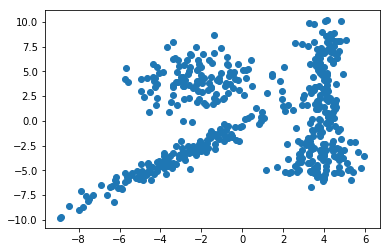

In [5]:
plt.scatter(data_train[:,0], data_train[:,1])
plt.show()

# 2 First approach: k-means algorithm

2/ Use the $k$-means algorithm in order to cluster the data into $K$ classes stored in vector $z\in\{0,1,2,3\}^T$. Return the the vector $\tau \in \{0,1\}^{T \times K}$ such that
$
\tau_{t,k} = 
\begin{cases}
1 & \text{if}\;\;z_t=k\\
0 & \text{otherwise}.
\end{cases}
$

Hint: use the $\texttt{sklearn}$ library.

In [4]:
def kmeans(x, K):
    """
    inputs:
    x : [T,D], T points of dimension D 
    K : integer, number of clusters
    outputs:
    tau [T,k] output, one-hot encoding of the clustering in k classes
    """
    T = x.shape[0]
    kmeans = KMeans(n_clusters=K, random_state=0).fit(x)
    z = kmeans.labels_
    tau = np.zeros((T, K),dtype='f8')
    for t in range(T):
        tau[t,z[t]] = 1
    return tau

3/ Compute and plot the k-means affectation for $K=4$. <font color=red> What assumption of the $k$-means algorithm is not well-suited to the data?
    
    it assumes the distributions are spherical

In [5]:
def plot_affectation(x, cluster_indices):
    colors = ['k', 'r', 'g', 'b']
    markers = [ 'o', 's', '+', 'x']
    for i_state in range(n_state):
        plt.scatter(x[cluster_indices==i_state,0], x[cluster_indices==i_state,1], c=colors[i_state], marker=markers[i_state])

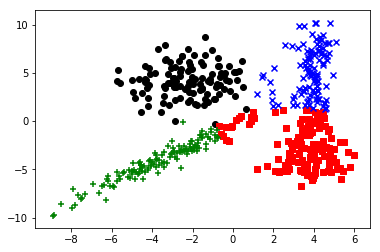

In [6]:
tau=kmeans(data_train, 4)
plot_affectation(data_train, tau.argmax(1))

# 3 EM-algorithm for the Gaussian Mixture Model

We first model the data by a Gaussian Mixture Model (GMM): the observed data is comprised of $T$ i.i.d random variables $X_t \mapsto \mathbb{R}^{2}$  which follow a mixture of $K$ Gaussians. The choice of the Gaussian component in the mixture is determined by a latent variable $Z_t \mapsto \{0,\cdots,K-1\}$ following a multinomial distribution.
To each entry $t \in [0,\cdots,T-1]$ we associate an observation $x_t$ and a latent variable $z_t$, and denote by $x\in \mathbb{R}^{T \times 2}$ the vector of $T$ observations and $z\in \{0,\cdots,K-1\}^{T}$ a corresponding vector of latent variables.

$$
p(x,z) = \prod_{t=0}^{T-1} p(x_t,z_t) = \prod_{t=0}^{T-1} p(z_t) p(x_t \mid z_t)~.
$$

The latent variables follow each a multinomial distribution parameterized by $\pi \in \mathbb{R}^K$: 
$$
p(z_t=k) = \pi_k~.
$$
The conditional probability $p(x_t \mid z_t=k)$ follows a Gaussian distribution parameterized by the centroid $\mu_k \in \mathbb{R}^{2}$ and covariance  matrix $\Sigma_k \in \mathbb{R}^{ 2 \times 2}$:
$$
p(x_t\mid z_t=k) \sim \frac1{(2\pi)^{D/2} \mid\Sigma_i\mid^{1/2}}
\exp{\left(-\frac12(x_t-\mu_k)^\intercal \Sigma_k^{-1} (x_t-\mu_k)\right)},
$$

5 / Draw the model in plate notation.

6 / Complete the function $\texttt{log_gaussian}(x, mu, Sigma)$ which returns the logarithm of the emission probability of value $x$ by a normal distribution parameterized by $\mu$ and $\Sigma$. Run the test cell to check if your code is correct.

Hint: use `np.linalg.det` and `np.linalg.inv`

In [7]:
def log_gaussian(x, mu, Sigma):
    """
    inputs:
    x : [T,D], input T points of dimension D
    mu : [D,], centroid
    Sigma : [D,D], centroid
    outputs:
    float, log probability of x being generated by the gaussian N(mu, sigma)
    """
    vec_diff = x - mu
    return - 0.5 * (np.dot(vec_diff, np.linalg.inv(Sigma))*vec_diff).sum(1) \
        - 0.5 * n_dimension * np.log(2*np.pi) - 0.5 * np.log(np.linalg.det(Sigma))

In [8]:
#the next assert checks the correcteness of the log-gaussian function's code! the assert must pass
mu = np.array([1,1])
Sigma = np.array([[1,0.5],[0.3,2]])
x = np.array([[1,0],[10,1]])
vec_diff = x - mu
assert((np.abs(log_gaussian(x, mu, Sigma)-np.array([ -2.41574016, -45.92925367]))<1e-8).all())
(np.dot(vec_diff, np.linalg.inv(Sigma))*vec_diff).sum(1) 

array([ 0.54054054, 87.56756757])

8 / Complete the function $\texttt{log_all_gaussians}(x, mus, Sigmas)$ which returns $p(x_t \mid z_t=k)$ for all the $k$ Gaussian distributions parameterized by $\mu_k$ and $\Sigma_k$:
$$
[p]_{t,k}=p(x_t \mid z_t=k)
$$

In [9]:
def log_all_gaussians(x, mus, Sigmas):
    """
    inputs:
    x : [T,D] T input points of dimension D
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    outputs:
    [T,K]  probability that each data point x_t was generated by the k-th mixture
    """
    n_state = mus.shape[0]
    log_proba = np.zeros((x.shape[0], n_state),dtype='f8')
    for i_state in range(n_state):
        log_proba[:,i_state] = log_gaussian(x, mus[i_state,:], Sigmas[i_state,:,:])
    return log_proba

In [10]:
#another code check
mus = np.array([[1,1],[5,5]])
Sigmas = np.array([[[1,0.5],[0.3,2]],[[2,0.5],[0.9,2]]])
x = np.array([[1,0],[10,1]])
assert((np.abs(log_all_gaussians(x, mus, Sigmas)-np.array([[ -2.41574016, -10.07698467], [-45.92925367, -17.96430861]]))<1e-7).all())

6 / Complete the function $\texttt{M_step_mixture}$ which implements the M-step of an EM algorithm for a GMM model. This function returns the parameters $\hat{\pi},\hat{\mu}, \hat{\Sigma}$ learnt from the expected latent variables $\tau_{t,k}=p(z_t=k \mid x; \theta_\text{current})$.

Reminder:
$$
\hat{\pi}_k = \frac{\sum_{t=0}^{T-1}\tau_{t,k}}{T} 
$$
$$
\hat{\mu}_k = \frac{\sum_{t=0}^{T-1}\tau_{t,k} x_t}{\sum_{t=0}^{T-1} \tau_{t,k}} 
$$
$$
\hat{\Sigma}_k = \frac{\sum_{t=0}^{T-1}\tau_{t,k} (x_t-\hat{\mu_k})(x_t-\hat{\mu_k})^\intercal}{\sum_{t=0}^{T-1} \tau_{t,k}} 
$$

In [11]:
#M-step
def M_step_mixture(x, tau):
    """
    x : [T,D] T input points of dimension D
    tau : [T,K] expected latent variable
    outputs:
    pi : [K,] the Multinomial parameters of z
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    """
    pi = np.zeros((n_state,),dtype='f8')
    mus = np.zeros((n_state, n_dimension),dtype='f8')
    Sigmas = np.zeros((n_state, n_dimension, n_dimension),dtype='f8')
    tau_sum  = tau.sum(0)
    pi = tau_sum/x.shape[0]
    mus = (tau[:,:,None] * x[:,None,:]).sum(0)/ tau_sum[:,None]
    for k_state in range(n_state):
        x_diff = x - mus[k_state,:][None,:]
        Sigmas[k_state,:,:] = 1/tau_sum[k_state]*(x_diff[:,None,:]*x_diff[:,:,None]*((tau[:,k_state])[:,None,None])).sum(0)
    return pi, mus, Sigmas

5/ Compute $\pi, (\mu_k, \Sigma_k)_k, $ with the value of $\tau$ obtained with $k$-means. Use the function $\texttt{plot_model}(\tau, mus, Sigmas)$ to represent the iso-density contour of each Gaussians. <font color=red> Why does it make sens to use the $\tau$ from k-means with an M-step to compute the parameters of the Gaussians.
    
    the M step done with k means hard assignments corresponds to fitting ellipsoides around the clusters
    

In [12]:
def plot_model(x, tau, mus, Sigmas):
    def plot_gaussian(mu, Sigma):
        x, y = np.meshgrid(np.linspace(-10, 10, 100),
                       np.linspace(-10, 10, 100))
        def gauss(x,y): return np.exp(log_gaussian(np.array([x,y])[None,:], mu, Sigma)[0])
        vec_gaussian = np.vectorize(gauss)
        plt.contour(x, y, vec_gaussian(x, y),3)
    plt.clf()
    colors = ['k', 'r', 'g', 'b']
    markers = [ 'o', 's', '+', 'x']
    z = tau.argmax(1)
    for k_state in range(n_state):
        plt.scatter(x[z==k_state,0], x[z==k_state,1], c=colors[k_state], marker=markers[k_state])
        plot_gaussian(mus[k_state,:], Sigmas[k_state,:,:])

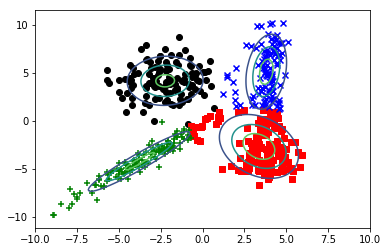

In [13]:
tau=kmeans(data_train, 4)
pi, mus, Sigmas = M_step_mixture(data_train, tau)
plot_model(data_train, tau, mus, Sigmas)

7/ Complete the function $\texttt{logsumexp}(X)=\log(\sum_k(\exp(X_k)))$ which compute the logarithm of sum on the last dimension of elementwise exponentials of an array in a robust way. Try it on the example below, and explain why the naive approach doesn't work.

<font color=red> Justify why this might be necessary when handling normal distributions.
    
    underflow

In [14]:
def logsumexp(x):
    """
    #compute log(sum(exp(x))) avoiding numerical underflow
    """    
    max_per_line = x.max(-1, keepdims=True)
    return (max_per_line + np.log(np.sum(np.exp(x-max_per_line),-1, keepdims=True))).squeeze()

In [15]:
test_value = np.array([-1000, -2000, -1001])
naive = np.log(np.sum(np.exp(test_value)))
robust = logsumexp(test_value)
print("naive = %f / robust = %f" % (naive, robust))

naive = -inf / robust = -999.686738


D:\research\python\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


7 / Complete the function $\texttt{E_step_mixture}(x, \pi, mus, Sigmas)$ which returns the expected latent values $\tau_{t,k}=p(z_t=k \mid x: \theta_\text{current})$ given by the mixture parameterization $\pi, (\mu_k, \Sigma_k)_k$. <font color='red'> Prove that <font color='black'>:
$$
p(z_t=k \mid x; \theta_\text{current})=\frac{p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})}{\sum_{k=0}^{K-1} p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})}
$$
    
    see class material
    

In [16]:
def E_step_mixture(x, pi, mus, Sigmas):
    """
    inputs:
    x : [T,D] T input points of dimension D
    pi : [K,] the Multinomial parameters of z
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    outputs:
    tau : [T,K] expected latent variable
    """
    log_tau_unnormalized = log_all_gaussians(x, mus, Sigmas) + np.log(pi[None,:])
    return np.exp(log_tau_unnormalized - logsumexp(log_tau_unnormalized)[:,None])   

In [17]:
#check that the taus are probabilities
tau = E_step_mixture(data_train, pi, mus, Sigmas)
assert((np.abs(tau.sum(1)-1)<1e-8).all())

8 / Complete the function $\texttt{avg_log_likelihood_mixture}(x)=\log(p(x;\theta_\text{current}))$ which returns the loglikelihood of the vector of observations  $x$ given a Gaussian mixture model parameterized by $\pi, (\mu_k, \Sigma_k)_k$ and normalized by the number of observations.
$$
L(x;\theta_\text{current})=\frac1T \sum_{t=0}^{T-1}\log(p(x_t;\theta_\text{current}))=\frac1T \sum_{t=0}^{T-1}\log\left(\sum_{k=0}^{K-1} p(x_t,z_t=k;\theta_\text{current})\right)
$$

In [18]:
def avg_log_likelihood_mixture(x, pi, mus, Sigmas):
    """
    inputs:
    x : [T,D] T input points of dimension D
    pi : [K,] the Multinomial parameters of z
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    outputs:
    log-likelihood of x
    """
    log_tau_unnormalized = log_all_gaussians(x, mus, Sigmas) + np.log(pi[None,:])
    return (logsumexp(log_tau_unnormalized).sum()) / x.shape[0]

9 / Implement the EM algorithm to learn the mixture parameters $\pi, (\mu_k, \Sigma_k)_k$ from the training set with $K=4$. Initialize with $k$-means. Print the likelihood at each step, what do we observe?

In [19]:
def EM_mixture(x):
    """
    inputs:
    x : [T,D] T input points of dimension D
    outputs:
    pi0 : [K,] initial Multinomial
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    tau : [T,K] expected latent variable
    """
    n_ite = 50
    #first E-step
    tau = kmeans(x, 4)
    #main loop
    for i_ite in range(n_ite):
        #M-step
        pi, mus, Sigmas = M_step_mixture(x, tau)
        #E-step
        tau = E_step_mixture(x, pi, mus, Sigmas)
        #likelihood
        print("Mixture iteration %d  - loglikelihood = %1.3f" % (i_ite, avg_log_likelihood_mixture(x, pi, mus, Sigmas)))
    return pi, mus, Sigmas, tau

Mixture iteration 0  - loglikelihood = -4.784
Mixture iteration 1  - loglikelihood = -4.712
Mixture iteration 2  - loglikelihood = -4.678
Mixture iteration 3  - loglikelihood = -4.669
Mixture iteration 4  - loglikelihood = -4.665
Mixture iteration 5  - loglikelihood = -4.662
Mixture iteration 6  - loglikelihood = -4.660
Mixture iteration 7  - loglikelihood = -4.659
Mixture iteration 8  - loglikelihood = -4.658
Mixture iteration 9  - loglikelihood = -4.657
Mixture iteration 10  - loglikelihood = -4.657
Mixture iteration 11  - loglikelihood = -4.656
Mixture iteration 12  - loglikelihood = -4.656
Mixture iteration 13  - loglikelihood = -4.656
Mixture iteration 14  - loglikelihood = -4.656
Mixture iteration 15  - loglikelihood = -4.656
Mixture iteration 16  - loglikelihood = -4.656
Mixture iteration 17  - loglikelihood = -4.656
Mixture iteration 18  - loglikelihood = -4.655
Mixture iteration 19  - loglikelihood = -4.655
Mixture iteration 20  - loglikelihood = -4.655
Mixture iteration 21  -

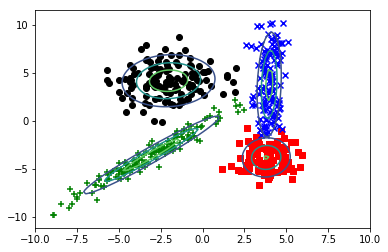

In [20]:
pi, mus, Sigmas, tau = EM_mixture(data_train)
plot_model(data_train, tau, mus, Sigmas)
plt.show()

In [21]:
avg_log_likelihood_mixture(data_train, pi, mus, Sigmas)

-4.65543135125355

9 / Compute the log-likelihood of the test data, visualize the data and comment.

-4.817958858230584

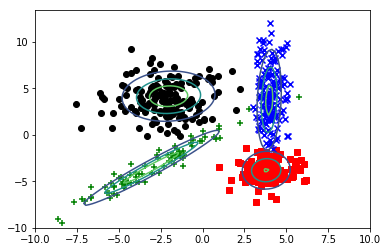

In [22]:
tau = E_step_mixture(data_test, pi, mus, Sigmas)
plot_model(data_test, tau, mus, Sigmas)
avg_log_likelihood_mixture(data_test, pi, mus, Sigmas)

# 4 Hidden Markov Model

10 / We now take into account the temporal structure of the data with a chain-structured hidden Markov model with discrete latent variable $z\in\{0,\cdots,K-1\}^T$:
$$
p(x, z) = p(z_0)\prod_{t=0}^{T-1}  p(x_t \mid z_t)\prod_{t=1}^{T-1} p(z_t \mid z_{t-1}).
$$
We model $p(x_t \mid z_t = k) \sim \mathcal{N}(\mu_k, \Sigma_k)$ like in the previous model, and $p(z_{t+1}=k \mid z_{t}=l)=A_{k,l}$ and finally $p(z_0)$ with a multinomial distribution parameterized by $\pi_0$.

We initialize the Gaussian parameters $\mu_k$ and $\Sigma_k$ with the values $\hat{\mu_k}$ and $\hat{\Sigma_k}$ computed in the mixture model. We initalize $\pi_0$ and $A$ as follows:
$$
\pi_0=\hat{\pi}
$$

$$
[A]_{k,l}=\hat{\pi}_k
$$
Complete the next cell to initialize $A$ and $\pi_0$. <font color = red> How can we interpret this initialization?
    
    the transiion matrix A does not depend from the previous state. This model hence corresponds to the mixture model.

In [56]:
A = np.tile(pi, (n_state,1)).T
pi0 = pi

10 / Complete the function $\texttt{alpha_beta}(x, pi,mus,Sigmas, A)$ which peforms the marginal inference of the model.

we have the following formulas for the alpha and beta recursions:
$$
\alpha(z_{t}) = p(x_0, \cdots, x_t, z_t)  = p(x_t \mid z_t)\sum_{z_{t-1}=0}^{K-1}\alpha(z_{t-1})\;p(z_{t} \mid z_{t-1})
$$
$$
\beta(z_{t}) = p(x_{t+1}, \cdots, x_T \mid z_t) = \sum_{z_{t+1}=0}^{K-1}\beta(z_{t+1})\;p(z_{t+1}\mid z_{t})\;p(x_{t+1} \mid z_{t+1})
$$

In [57]:
def alpha_beta(x, pi0, mus, Sigmas, A):
    """
    inputs:
    x : [T,D] T input points of dimension D
    pi0 : [K,] initial Multinomial
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    A : [K,K] transition probability
    outputs:
    log_proba_emission [T,K] the probability that each data point x_t was generated by the k-th mixture
    """
    T = x.shape[0]
    log_proba_emission = log_all_gaussians(x, mus, Sigmas)

    #forward pass
    log_alpha = np.zeros((T, n_state), dtype=('f8'))
    log_alpha[0,:] = np.log(pi0) + log_proba_emission[0,:]
    for t in range(1,T):
        log_alpha[t,] = log_proba_emission[t,] + logsumexp(log_alpha[t-1,] + np.log(A.transpose()))
    #backward pass
    log_beta = np.zeros((T, n_state), dtype=('f8'))  
    for t in range(T-2,-1,-1):
        log_beta[t,] = logsumexp(log_beta[t+1,] + log_proba_emission[t+1,] + np.log(A))
    return log_proba_emission, log_alpha, log_beta

In [58]:
log_proba_emission, log_alpha, log_beta = alpha_beta(data_train, pi0, mus, Sigmas, A)

11 / Compute the first order marginal probability $\gamma_t= {p(z_t \mid x)}$. Check that the normalization factor is the same for all $t$. Why is that the case? 
Reminder:
$$
\gamma(z_t)=p(z_t \mid x) \propto {\alpha(z_t)\beta(z_t)}
$$

In [59]:
#marginal inference - first order
log_gamma_unnormalized = log_alpha + log_beta
normalizing_factor = logsumexp(log_gamma_unnormalized)[:,None]
log_gamma = log_gamma_unnormalized - normalizing_factor
assert((np.abs(normalizing_factor.std())<1e-8).all())
normalizing_factor[0]

array([-2329.47341826])

In [72]:
log_gamma[1:100,:]

array([[ 0.00000000e+00, -6.04655648e+01, -1.44461040e+02,
        -1.12664123e+02],
       [-1.13304607e+01, -5.05298459e+01, -3.71251823e+01,
        -1.20017910e-05],
       [-3.21234675e+00, -1.81027467e+01, -4.10949809e-02,
        -5.85490894e+01],
       [-2.70739437e+01, -5.43865616e+01, -1.81898940e-12,
        -2.43148154e+02],
       [-2.23752390e+01, -4.26213112e+01, -1.91676008e-10,
        -1.85524660e+02],
       [-6.22400080e+00, -1.39705883e+01, -1.98412597e-03,
        -2.67357966e+01],
       [-1.29370063e+01, -3.46595877e+01, -1.29617199e+01,
        -4.75584011e-06],
       [ 0.00000000e+00, -7.41850124e+01, -1.58613628e+02,
        -2.43037407e+02],
       [-1.89155725e+01, -8.24904393e+00, -3.87794138e+01,
        -2.61548755e-04],
       [ 0.00000000e+00, -4.71752586e+01, -7.60984769e+01,
        -9.67740937e+01],
       [-1.38847894e+01, -3.13922871e+01, -1.56822690e+01,
        -1.08769109e-06],
       [ 0.00000000e+00, -3.41115865e+01, -4.83109265e+01,
      

Plot the evolution of the most likely state for each of the first 100 point and comment. <font color = red> How good was our initialization of $A$?
    
    not so good, our model is very different from the mixture model. indeed some state seems to attract one another, transition 0-<>3 and 3->0 have high empirical probability. However it was good enough an initialisation for convergence to satisfying parameters.

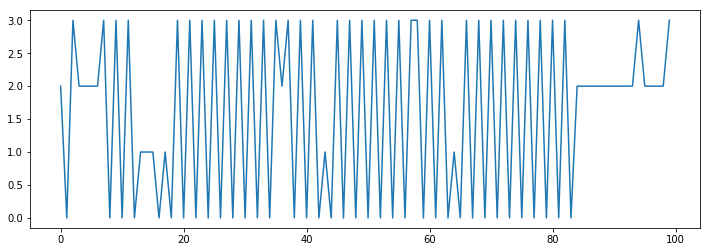

In [60]:
z = np.argmax(log_gamma,1)
figure(figsize=(12,4))
plt.plot(z[0:100])
plt.show()

12 / Compute the pairwise marginals $\xi(z_{t-1},z_t)=p(z_{t-1},z_{t} \mid x; \theta_\text{current})$.

Reminder:
$$
\xi(z_{t-1},z_t)= \frac{\alpha(z_{t-1}) p(x_t \mid z_t; \theta_\text{current}) p(z_t \mid z_{t-1}; \theta_\text{current}) \beta(z_t)}{p(x; \theta_\text{current})}
$$

In [61]:
log_xi = log_proba_emission[1:,None,:] + log_alpha[:-1,:,None] + log_beta[1:,None,:] + np.log(A[None,:,:]) - normalizing_factor[0]
#code check: the pair marginals are indeed probabilities
assert((np.abs(np.exp(log_xi).sum(1).sum(1)-1)<1e-10).all())

13 / Complete the function $\texttt{E_step_HMM}(pi,mus,Sigmas, A)$ which returns the singleton and pairwise marginals as well as the averaged loglikelihood of the observation.

In [62]:
def E_step_HMM(x, pi0, mus,Sigmas, A):
    log_proba_emission, log_alpha, log_beta = alpha_beta(x, pi0, mus,Sigmas, A)
    log_gamma_unnormalized = log_alpha + log_beta
    log_likelihood = logsumexp(log_gamma_unnormalized)
    log_gamma = log_gamma_unnormalized - log_likelihood[:,None]
    log_xi = log_proba_emission[1:,None,:] + log_alpha[:-1,:,None] + log_beta[1:,None,:] + np.log(A[None,:,:]) - log_likelihood[0]
    return log_gamma, log_xi, log_likelihood[0]/x.shape[0]

14 / Complete the function $\texttt{M_step_HMM}(\gamma, \xi)$ for the HMM model which returns the parameters $\hat{\mu}_k,\hat{\Sigma}_k, \hat{A}$.

$$
[\hat{A}]_{k,l}=\frac{\sum_{t=0}^{T-2}p(z_{t+1}=k,z_{t}=l \mid x; \theta_\text{current})}{\sum_{t=0}^{T-2}\sum_{j=0}^{K-1} p(z_{t+1}=j,z_{t}=l \mid x; \theta_\text{current})}
$$

In [63]:
def M_step_HMM(x, log_gamma, log_xi):
    pi, mus, Sigmas = M_step_mixture(x, np.exp(log_gamma))
    A = np.exp(log_xi).sum(0) / np.exp(log_xi).sum(0).sum(0)
    pi0 = np.exp(log_gamma[0,:])
    return pi0, mus, Sigmas, A

In [64]:
pi0, mus, Sigmas, A =  M_step_HMM(data_train, log_gamma, log_xi)
#a code check that A is indeed a conditional probability
assert(np.all(np.abs(A.sum(0)-1)<1e-10))

16 / Implement the EM algorithm for the HMM model. Initialize the parameters with EM on the Gaussian mixture model.

Mixture iteration 0  - loglikelihood = -4.784
Mixture iteration 1  - loglikelihood = -4.712
Mixture iteration 2  - loglikelihood = -4.678
Mixture iteration 3  - loglikelihood = -4.669
Mixture iteration 4  - loglikelihood = -4.665
Mixture iteration 5  - loglikelihood = -4.662
Mixture iteration 6  - loglikelihood = -4.660
Mixture iteration 7  - loglikelihood = -4.659
Mixture iteration 8  - loglikelihood = -4.658
Mixture iteration 9  - loglikelihood = -4.657
Mixture iteration 10  - loglikelihood = -4.657
Mixture iteration 11  - loglikelihood = -4.656
Mixture iteration 12  - loglikelihood = -4.656
Mixture iteration 13  - loglikelihood = -4.656
Mixture iteration 14  - loglikelihood = -4.656
Mixture iteration 15  - loglikelihood = -4.656
Mixture iteration 16  - loglikelihood = -4.656
Mixture iteration 17  - loglikelihood = -4.656
Mixture iteration 18  - loglikelihood = -4.655
Mixture iteration 19  - loglikelihood = -4.655
Mixture iteration 20  - loglikelihood = -4.655
Mixture iteration 21  -

D:\research\python\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


HMM iteration 47  - likelihood = -3.794
HMM iteration 48  - likelihood = -3.794
HMM iteration 49  - likelihood = -3.794
HMM iteration 50  - likelihood = -3.794
HMM iteration 51  - likelihood = -3.794
HMM iteration 52  - likelihood = -3.794
HMM iteration 53  - likelihood = -3.794
HMM iteration 54  - likelihood = -3.794
HMM iteration 55  - likelihood = -3.794
HMM iteration 56  - likelihood = -3.794
HMM iteration 57  - likelihood = -3.794
HMM iteration 58  - likelihood = -3.794
HMM iteration 59  - likelihood = -3.794
HMM iteration 60  - likelihood = -3.794
HMM iteration 61  - likelihood = -3.794
HMM iteration 62  - likelihood = -3.794
HMM iteration 63  - likelihood = -3.794
HMM iteration 64  - likelihood = -3.794
HMM iteration 65  - likelihood = -3.794
HMM iteration 66  - likelihood = -3.794
HMM iteration 67  - likelihood = -3.794
HMM iteration 68  - likelihood = -3.794
HMM iteration 69  - likelihood = -3.794
HMM iteration 70  - likelihood = -3.794
HMM iteration 71  - likelihood = -3.794


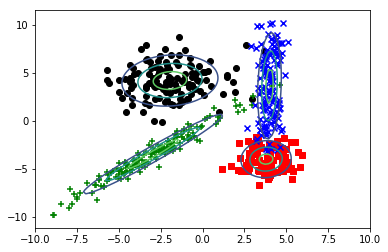

In [65]:
#init with mixture
pi, mus, Sigmas, tau = EM_mixture(data_train)
A = np.tile(pi, (n_state,1))
pi0 = pi
n_ite = 100
#main loop
for i_ite in range(100):    
    #E-step
    log_gamma, log_xi, log_likelihood = E_step_HMM(data_train, pi0, mus, Sigmas, A)    
    print("HMM iteration %d  - likelihood = %1.3f" % (i_ite, log_likelihood))
    #M-step
    pi0, mus, Sigmas, A = M_step_HMM(data_train, log_gamma, log_xi)
    
plot_model(data_train, np.exp(log_gamma), mus, Sigmas)
plt.show()

18/ Compute the final loglikelihood on the training set and compare it to the one obtained with the mixture model. <font color='red'> Is it a surprising result? Explain why? Make the same comparison on the test set. What conclusion can we draw now?</font>

Since HMM model ave more parameters, it is expected that it has higher log likelihood on the training set. Since it also has a higher log likelihood for the test set we can assume that it is a better model. The data were more likely generated from an HMM than a GMM.

In [66]:
_log_gamma, _log_xi, log_likelihood_train = E_step_HMM(data_train, pi0, mus, Sigmas, A)
_log_gamma, _log_xi, log_likelihood_test = E_step_HMM(data_test, pi0, mus, Sigmas, A)
print("likelihood train %1.3f  - likelihood test= %1.3f" % (log_likelihood_train, log_likelihood_test))

likelihood train -3.794  - likelihood test= -3.910


D:\research\python\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


19/ <font color = red> If we didn't know in advance the number of states, how would we choose it?
    
    cross entropy on test set likelihood

20 / Implement the Viterbi algorithm for MAP inference / decoding. <font color = red> Explain the difference between marginal and MAP inference.
</font>

see class material. computing marginalprobability $\neq$ computing the best sequence. 

Reminder:
the Viterbi algorithm is also called max-product. It computes the sequence of state with the maximum likelihood. It defines $p^\text{map}_{t,i}$ as the probability that the most probable path $0\cdots,t$ end in state $i$. We have the following recursion:
$$
p^\text{map}_{t,i} = p(x_t,z_t=i;\theta_\text{current}) \;\max_j( p^\text{map}_{t-1,j}\; p(z_t=i \mid z_{t-1}=j;\theta_\text{current})
$$
Once $p^\text{map}_{T,i}$ is computed, the last state of the map sequence is $\text{argmax}(p^\text{map}_{T,i})$. To compute the previous state, one simply backtrack through the selected transition computed earlier (keep track of the argmax!).

In [67]:
def viterbi(x, pi0, mus, Sigmas, A):
    T = x.shape[0]
    log_proba_emission = log_all_gaussians(x, mus, Sigmas)
    map_state = np.zeros((T,), dtype='uint8') #the map sequence
    best_proba = np.zeros((T,n_state), dtype='f8') #probability of best sequence 1..t being in state i
    best_previous_state = np.zeros((T,n_state), dtype='uint8') #state of the previous observation in the best sequence 1..t
    #init
    best_proba[0,:] = np.log(pi0) + log_proba_emission[0,:]
    best_previous_state[0,:] = np.NaN #no previous observation
    #forward pass
    for t in range(1,T):
        proba_previous_state = best_proba[t-1,] + np.log(A.transpose())
        best_proba[t,] = log_proba_emission[t,] + np.max(proba_previous_state,1).squeeze()
        best_previous_state[t,] = np.argmax(proba_previous_state,1)
    #backward pass
    map_state[-1] = best_proba[-1,:].argmax()
    map_state
    for t in range(T-2,0,-1):
        map_state[t] = best_previous_state[t+1,map_state[t+1]]
    return map_state, best_previous_state

D:\research\python\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


array([[0, 0, 0, 0],
       [2, 2, 2, 2],
       [0, 0, 0, 0],
       ...,
       [2, 2, 2, 2],
       [2, 2, 2, 2],
       [2, 2, 2, 2]], dtype=uint8)

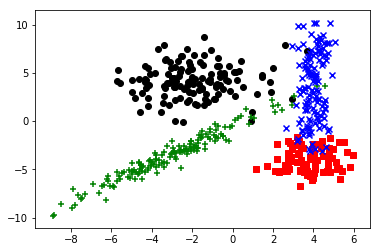

In [68]:
map_state, best_previous_state = viterbi(data_train, pi0, mus,Sigmas, A)
plot_affectation(data_train, map_state)
best_previous_state

21 / Launch the visualiziation below representing the backtracking of the Viterbi algorithm. Interpret and comment.

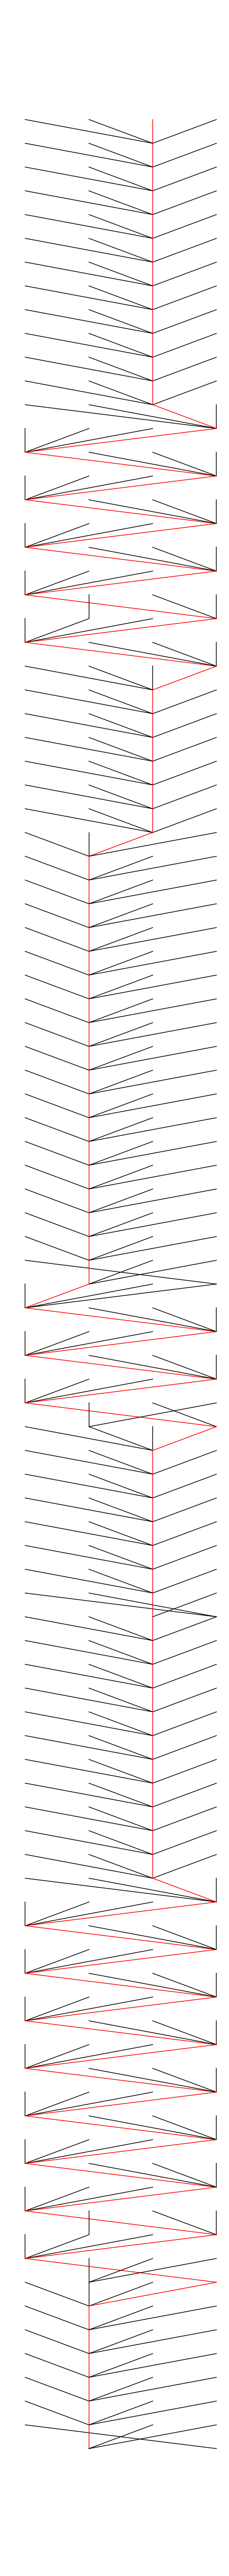

In [69]:
figure(num=None, figsize=(8, 100), dpi=80, facecolor='w', edgecolor='k')
plt.axis('off')
for t in range(n_point-2,n_point-100,-1):
    for i_state in range(n_state):
        if best_previous_state[t,i_state]==map_state[t-1] and i_state==map_state[t]:
            c = 'r'
        else:
            c = 'k'
        plt.plot([i_state, best_previous_state[t,i_state]],[t, t-1], c)
best_previous_state[-10:-1,:] 
plt.show()